In [1]:
import warnings

warnings.filterwarnings('ignore')


## 数据读入

In [2]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [3]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"
             ]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [4]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [5]:
# train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
# test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [6]:
drop_col = []

train_data.drop(drop_col, inplace=True)
test_data.drop(drop_col, inplace=True)


## loan1表

In [7]:
if True:

    import pandas as pd
    temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")

    def chuli_loan(df, colname, ways):
        cust_id = list(range(len(set(df['cust_id']))))
        res_df = pd.DataFrame({'cust_id': cust_id})
        
        if 'mean' in ways:
            res_df[colname+'_mean'] = df.groupby('cust_id')[colname].mean()
        if 'sum' in ways:
            res_df[colname+'_sum'] = df.groupby('cust_id')[colname].sum()
        if 'count' in ways:
            res_df[colname+'_count'] = df.groupby('cust_id')[colname].count()
        if 'std' in ways:
            res_df[colname+'_std'] = df.groupby('cust_id')[colname].std()
        if 'min' in ways:
            res_df[colname+'_min'] = df.groupby('cust_id')[colname].min()
        if 'diff_std' in ways:
            res_df[colname+'_diff_std'] = df.groupby('cust_id')[colname].apply(
                lambda x: x.sort_values(ascending=True).diff()[2:].std())
        return res_df

    for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
        df = chuli_loan(temp_df, colname, ('sum','mean','std'))
        train_data = pd.merge(train_data, df, on="cust_id",
                              how="left", suffixes=("", "_y"))
        test_data = pd.merge(test_data, df, on="cust_id",
                             how="left", suffixes=("", "_y"))

    # df = chuli_loan(temp_df, 'date_3', ('count',))
    # train_data = pd.merge(train_data, df, on="cust_id",
    #                       how="left", suffixes=("", "_y"))
    # test_data = pd.merge(test_data, df, on="cust_id",
    #                      how="left", suffixes=("", "_y"))

    # df = chuli_loan(temp_df, 'date_1', ('min',))
    # train_data = pd.merge(train_data, df, on="cust_id",
    #                       how="left", suffixes=("", "_y"))
    # test_data = pd.merge(test_data, df, on="cust_id",
    #                      how="left", suffixes=("", "_y"))

    # df = chuli_loan(temp_df, 'loan1_10', ('mean',))
    # train_data = pd.merge(train_data, df, on="cust_id",
    #                       how="left", suffixes=("", "_y"))
    # test_data = pd.merge(test_data, df, on="cust_id",
    #                      how="left", suffixes=("", "_y"))

    # df = chuli_loan(temp_df, 'loan1_11', ('sum',))
    # train_data = pd.merge(train_data, df, on="cust_id",
    #                       how="left", suffixes=("", "_y"))
    # test_data = pd.merge(test_data, df, on="cust_id",
    #                      how="left", suffixes=("", "_y"))

    # df = chuli_loan(temp_df, 'loan1_12', ('sum',))
    # train_data = pd.merge(train_data, df, on="cust_id",
    #                       how="left", suffixes=("", "_y"))
    # test_data = pd.merge(test_data, df, on="cust_id",
    #                      how="left", suffixes=("", "_y"))

    train_data.to_csv('./data/df_train.csv')
    test_data.to_csv('./data/df_test.csv')


In [8]:
# data = temp_df.dropna(axis=0,subset = ["date_1"])
# data['date2-date1'] = data['date_2'] - data['date_1']
# data['date3-date2'] = data['date_3'] - data['date_2']
# data['dateinterval_max'] = data[['date2-date1','date3-date2']].max(axis=1)
# data = data.groupby('cust_id').agg({'date_2':['count'],'date_3':['count'],'dateinterval_max':['mean']})
# train_data = pd.merge(train_data, data, on="cust_id",
#                           how="left", suffixes=("", "_y"))
# test_data = pd.merge(test_data, data, on="cust_id",
#                          how="left", suffixes=("", "_y"))


## 处理NAN

In [9]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [10]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [11]:
df_train.replace(-99, -1, inplace=True)
df_test.replace(-99, -1, inplace=True)


## 主成分分析（效果不好）

In [12]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [13]:
cat_way = "auto"


## 转化为one-hot编码（不宜采用）

In [14]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


## 类型计数

In [15]:
type_count_cols = ['industry', 'scope', 'basic_13']


In [16]:
# def type_count(cols):
#     global df_train, df_test
#     df1 = df_train[['cust_id']+cols]
#     df2 = df_test[['cust_id']+cols]
#     df = pd.concat([df1, df2], axis=0, ignore_index=True)
#     for i in cols:
#         temp_df = df.groupby(i)['cust_id'].count()
#         temp_df = pd.DataFrame({(i+"_num"): temp_df})
#         df = pd.merge(df, temp_df, on=i, how="left")
#         del df[i], df1[i], df2[i]
#     df_train = pd.merge(df_train, df, on="cust_id",
#                         how="left", suffixes=("", "_y"))
#     df_test = pd.merge(df_test, df, on="cust_id",
#                        how="left", suffixes=("", "_y"))


# type_count(type_count_cols)


## 证据权重

In [17]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        x1_set = pd.unique(df_no_label[i])
        for j in x1_set:
            if j not in x_set:
                df_no_label[i].replace(j, 0.03, inplace=True)
                print(i, j, '不存在')
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            if woe >= 0.1:
                n = np.sum(df[df[i] == j][y_col])
                print(i, '列：', j, ' 共有', int(n/woe), '个,其中',
                      int(n), '个label为1,woe为', woe, sep="")
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [18]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25", ]

# df_train,df_test=cal_woe(df_train,df_test,type_col,"label")


In [19]:
if cat_way == "auto" or cat_way == "no":
    type_col = ["basic_1",
                "basic_10",
                "basic_12",
                "basic_14",
                "loan1_16",
                "loan1_20",
                "loan1_23",
                "loan1_25",
                "loan2_1_y",
                "query_2_y",
                "query_3_y",
                "query_4_y",
                "query_5_y",
                "query_6_y", ]
if cat_way == "manual":
    woe_col = ['basic_1',
               'basic_5',
               'basic_6',
               'basic_10',
               'loan1_16',
               'loan1_20',
               'loan1_25',
               'loan1_23',
               'loan1_32',
               'loan2_4',
               'loan2_6',
               'overdue_2',
               'overdue_20',
               'overdue_21',
               'overdue_26',
               'overdue_27',
               'query_1',
               'query_2',
               'query_3',
               'query_4',
               'query_6',
               'query_7',
               'query_8',
               'query_10',
               'query_11', ]

    onehot_col = ['basic_12',
                  'basic_14',
                  'loan1_8',
                  'loan1_9',
                  'overdue_1',
                  'overdue_3',
                  'overdue_4',
                  'overdue_5',
                  'overdue_6',
                  'overdue_7',
                  'overdue_8',
                  'overdue_9',
                  'overdue_10',
                  'overdue_11',
                  'overdue_12',
                  'overdue_14',
                  'overdue_15',
                  'overdue_16',
                  'overdue_17',
                  'overdue_18',
                  'overdue_22',
                  'overdue_23',
                  'overdue_24',
                  'overdue_25',
                  'overdue_28',
                  'overdue_29',
                  'query_5',
                  'query_9', ]

    df_train, df_test = cal_woe(df_train, df_test, woe_col, "label")
    df_train = to_one_hot(df_train, onehot_col)
    df_test = to_one_hot(df_test, onehot_col)
    for i in df_train.columns:
        if i not in df_test.columns:
            df_test[i] = 0


In [20]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
date_col = [i for i in full_col_name if "date" in i]
# loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

# for i in judicial_col:
#     df_train[i].astype("float")
#     df_test[i].astype("float")


## rank化

In [21]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [22]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


# norm([i for i in loan_col if i not in type_col and 'count' not in i])


## 标准化

In [23]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i], axis=0))/np.std(df[i], axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


# stand([i for i in loan_col if i not in type_col and 'count' not in i])


## 设置哪些x作为模型自变量输入

In [24]:
# x_col = basic_col+loan_col+['nan_num'] + ['is_judicial']+ overdue_col+query_col
# x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col+['scope_num'] + \
#     ['industry_num']+['date_3_count', 'date_1_std', 'date_1_diff_std']

x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col+['date_1_min']
x_col = [i for i in x_col if i in full_col_name]

if cat_way == "auto":
    type_col = [i for i in type_col if i in x_col]
# categorize(df_train,type_col)
# categorize(df_test,type_col)

print('自变量个数为', len(x_col))
print(x_col)


自变量个数为 127
['basic_1', 'basic_2', 'basic_3', 'basic_4', 'basic_5', 'basic_6', 'basic_7', 'basic_8', 'basic_9', 'basic_10', 'basic_11', 'basic_12', 'basic_13', 'basic_14', 'basic_15', 'basic_1_y', 'basic_2_y', 'basic_3_y', 'is_judicial', 'loan1_1', 'loan1_2', 'loan1_3', 'loan1_4', 'loan1_5', 'loan1_6', 'loan1_7', 'loan1_8', 'loan1_9', 'loan1_10', 'loan1_11', 'loan1_12', 'loan1_13', 'loan1_14', 'loan1_15', 'loan1_16', 'loan1_17', 'loan1_18', 'loan1_19', 'loan1_20', 'loan1_21', 'loan1_22', 'loan1_23', 'loan1_24', 'loan1_25', 'loan1_26', 'loan1_27', 'loan1_28', 'loan1_29', 'loan1_30', 'loan1_31', 'loan1_32', 'loan1_33', 'loan2_1', 'loan2_2', 'loan2_3', 'loan2_4', 'loan2_5', 'loan2_6', 'loan2_7', 'loan2_8', 'loan2_9', 'loan2_10', 'loan2_11', 'loan2_12', 'loan2_1_y', 'loan2_2_y', 'loan2_3_y', 'loan2_4_y', 'loan2_5_y', 'loan1_1_mean', 'loan1_1_sum', 'loan1_1_std', 'loan1_3_mean', 'loan1_3_sum', 'loan1_3_std', 'loan1_7_mean', 'loan1_7_sum', 'loan1_7_std', 'loan1_9_mean', 'loan1_9_sum', 'loan1_

In [25]:
df_train = df_train[x_col+['label', 'cust_id']]
df_test = df_test[x_col+['cust_id']]

df_test.to_csv("test_input.csv", encoding='utf-8')


## 对抗验证

In [26]:
from sklearn import model_selection
import xgboost as xgb

df_full = pd.concat([df_train[x_col+['cust_id']], df_test],
                    axis=0, ignore_index=True)
df_full['label_test'] = [1 if i in df_test['cust_id']
                         else 0 for i in df_full['cust_id']]

df_full.to_csv("full.csv", encoding='utf-8')


In [27]:

X = df_full[x_col+['cust_id']]
Y = df_full['label_test']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.5, stratify=Y, random_state=2022)

dtrain = xgb.DMatrix(X_train[x_col], label=Y_train)
dtest = xgb.DMatrix(X_test[x_col], label=Y_test)

param = {'max_depth': 5,
         'eta': 0.1,
         'objective': 'binary:logistic',
         "eval_metric": "auc",
         "scale_pos_weight": 1,
         "subsample": 1,
         "min_child_weight": 1,
         'tree_method': 'gpu_hist',
         'gpu_id': 0, }

bst = xgb.train(param, dtrain, 400, evals=[(dtrain, "train"), (dtest, "test")],
                early_stopping_rounds=30, verbose_eval=True)
bst1 = xgb.train(param, dtest, 400, evals=[(dtest, "train"), (dtrain, "test")],
                 early_stopping_rounds=30, verbose_eval=False)


[0]	train-auc:0.54282	test-auc:0.49062
[1]	train-auc:0.54824	test-auc:0.48906
[2]	train-auc:0.57249	test-auc:0.48618
[3]	train-auc:0.57770	test-auc:0.48488
[4]	train-auc:0.58755	test-auc:0.48563
[5]	train-auc:0.60058	test-auc:0.48626
[6]	train-auc:0.61827	test-auc:0.48860
[7]	train-auc:0.62799	test-auc:0.48721
[8]	train-auc:0.63276	test-auc:0.48672
[9]	train-auc:0.64469	test-auc:0.48570
[10]	train-auc:0.65361	test-auc:0.48509
[11]	train-auc:0.67021	test-auc:0.48661
[12]	train-auc:0.67950	test-auc:0.48784
[13]	train-auc:0.68475	test-auc:0.48729
[14]	train-auc:0.68547	test-auc:0.48749
[15]	train-auc:0.69589	test-auc:0.49029
[16]	train-auc:0.70263	test-auc:0.49274
[17]	train-auc:0.70794	test-auc:0.49276
[18]	train-auc:0.71612	test-auc:0.49327
[19]	train-auc:0.72148	test-auc:0.49192
[20]	train-auc:0.72609	test-auc:0.49582
[21]	train-auc:0.73014	test-auc:0.49590
[22]	train-auc:0.73605	test-auc:0.49492
[23]	train-auc:0.73523	test-auc:0.49473
[24]	train-auc:0.73952	test-auc:0.49536
[25]	train

In [28]:
df_res = pd.DataFrame(
    {'cust_id': X_test['cust_id'], 'p_test': bst.predict(dtest)})
df_res1 = pd.DataFrame(
    {'cust_id': X_train['cust_id'], 'p_test': bst1.predict(dtrain)})

df = pd.concat([df_res, df_res1], axis=0, ignore_index=True)

df_train = pd.merge(df_train, df, on="cust_id",
                    how="left", suffixes=("", "_y"))


In [29]:
temp = len(df_train)
df_train.to_csv("train_input.csv", encoding='utf-8')

df_train = df_train[df_train['p_test'] >= 0.1]


print("经过对抗验证，有", len(df_train), "条数据被保留，",
      temp-len(df_train), "条数据被抛弃", sep="")


经过对抗验证，有17994条数据被保留，5条数据被抛弃


# 训练模型

## 超参数

In [30]:
N = 60
num_round = 3000
local_test_size = 3000

# 共用
test_size = [0.2, 0.3,0.4]
max_depth = [3, 4, 5]
subsample = [0.8, 0.75, 0.7, 0.65, 0.6]
early_stopping_rounds = 150

# XGB
eta = [0.007, 0.01]

# LGB
learning_rate = [0.03, 0.02, 0.025]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [31]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostClassifier


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []


X = df_train[x_col]
Y = df_train['label']

X, X_local_test, Y, Y_local_test = model_selection.train_test_split(
    X, Y, test_size=local_test_size, stratify=Y, random_state=2022)

X_local_test2,X_local_test1,Y_local_test2,Y_local_test1=model_selection.train_test_split(X_local_test,Y_local_test,test_size=1000,stratify=Y_local_test)
X_local_test3,X_local_test2,Y_local_test3,Y_local_test2=model_selection.train_test_split(X_local_test2,Y_local_test2,test_size=1000,stratify=Y_local_test2)

X_local_test1_xgb=xgb.DMatrix(X_local_test1)
X_local_test2_xgb=xgb.DMatrix(X_local_test2)
X_local_test3_xgb=xgb.DMatrix(X_local_test3)

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)
x_perd = xgb.DMatrix(df_test[x_col])

d_localtest1 = lgb.Dataset(X_local_test, Y_local_test)
x_perd1 = lgb.Dataset(df_test[x_col])


lgbcallback = [early_stopping(early_stopping_rounds), log_evaluation(10000)]


In [32]:

for i in range(N):

    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round, stratify=Y)

    # XGB-----------------------------------------------
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]
    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=early_stopping_rounds, verbose_eval=False)

    loss = roc_auc_score(y_test, bst.predict(dtest))
    train_loss = roc_auc_score(y_train, bst.predict(dtrain))
    local_test_loss1 = roc_auc_score(Y_local_test1, bst.predict(X_local_test1_xgb))
    local_test_loss2 = roc_auc_score(Y_local_test2, bst.predict(X_local_test2_xgb))
    local_test_loss3 = roc_auc_score(Y_local_test3, bst.predict(X_local_test3_xgb))

    pred_label = list(bst.predict(x_perd))

    test_label = list(bst.predict(d_localtest))

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc1': local_test_loss1,
                 'local_test_auc2': local_test_loss2,
                 'local_test_auc3': local_test_loss3,
                 'sum_test_loss':(loss+local_test_loss1+local_test_loss2+local_test_loss3)/4,
                 'model': 'xgb'}

    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    # if loss > max_auc_loss:
    #     best_bst = copy.deepcopy(bst)
    #     max_auc_loss = loss

    # if False:
    #     pic = xgb.plot_importance(bst, max_num_features=50)
    #     temp = pic.get_ymajorticklabels()
    #     important_x = [str(i).split("\'")[1] for i in temp]
    #     important_x.reverse()
    #     important_x_seq += important_x

    pred_labels.append(copy.deepcopy(pred_label))
    local_test_labels.append(copy.deepcopy(test_label))

    # LGB--------------------------------------------------------
    param = {
        'task': 'train',
        "max_depth": random.choice(max_depth),
        'max_bin': 128,
        'boosting_type': 'gbdt',  # 设置提升类型
        'objective': 'binary',  # 目标函数
        'metric': 'auc',  # 评估函数
        'learning_rate': random.choice(learning_rate),  # 学习速率
        'bagging_fraction': random.choice(subsample),  # 建树的样本采样比例
        'bagging_freq': 1,  # k 意味着每 k 次迭代执行bagging
        'min_data_in_leaf': 1,
        'verbose': -1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
        'device_type': 'gpu',
    }

    dtrain = lgb.Dataset(X_train, y_train)
    dtest = lgb.Dataset(X_test, y_test)

    if cat_way == "auto":
        bst1 = lgb.train(param, dtrain, num_round, valid_sets=[
            dtest], callbacks=lgbcallback, categorical_feature=type_col)
    else:
        bst1 = lgb.train(param, dtrain, num_round, valid_sets=[
            dtest], callbacks=lgbcallback)

    loss = roc_auc_score(y_test, bst1.predict(X_test))
    train_loss = roc_auc_score(y_train, bst1.predict(X_train))
    local_test_loss1 = roc_auc_score(Y_local_test1, bst1.predict(X_local_test1))
    local_test_loss2 = roc_auc_score(Y_local_test2, bst1.predict(X_local_test2))
    local_test_loss3 = roc_auc_score(Y_local_test3, bst1.predict(X_local_test3))


    pred_label = list(bst1.predict(df_test[x_col]))
    test_label = list(bst1.predict(X_local_test))

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc1': local_test_loss1,
                 'local_test_auc2': local_test_loss2,
                 'local_test_auc3': local_test_loss3,
                 'sum_test_loss':(loss+local_test_loss1+local_test_loss2+local_test_loss3)/4,
                 'model': 'lgb'}

    info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])
    pred_labels.append(copy.deepcopy(pred_label))
    local_test_labels.append(copy.deepcopy(test_label))

    # CAT-----------------------------------------------------------
    # bst2 = CatBoostClassifier(iterations=num_round,
    #                        depth=random.choice(max_depth),
    #                        learning_rate=random.choice(learning_rate),
    #                        loss_function='Logloss',
    #                        subsample=random.choice(subsample),
    #                        early_stopping_rounds=early_stopping_rounds,
    #                        verbose=False)
    # bst2.fit(X_train, y_train,eval_set=(X_test,y_test))

    # loss = roc_auc_score(y_test, bst2.predict_proba(X_test)[:,1])
    # train_loss = roc_auc_score(y_train, bst2.predict_proba(X_train)[:,1])
    # local_test_loss = roc_auc_score(Y_local_test, bst2.predict_proba(X_local_test)[:,1])
    # global_auc = roc_auc_score(df_train['label'], bst2.predict_proba(df_train[x_col])[:,1])

    # pred_label = list(bst2.predict_proba(df_test[x_col])[:,1])
    # test_label = list(bst2.predict_proba(X_local_test)[:,1])

    # temp_dict = {"test_auc": loss, "train_auc": train_loss,
    #              'local_test_auc': local_test_loss,
    #              'model': 'cat'}

    # info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])
    # pred_labels.append(copy.deepcopy(pred_label))
    # local_test_labels.append(copy.deepcopy(test_label))




Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[433]	valid_0's auc: 0.746259
Early stopping, best iteration is:
[485]	valid_0's auc: 0.746816
Early stopping, best iteration is:
[265]	valid_0's auc: 0.754526
Early stopping, best iteration is:
[265]	valid_0's auc: 0.754526
Early stopping, best iteration is:
[265]	valid_0's auc: 0.754526
Early stopping, best iteration is:
[265]	valid_0's auc: 0.754526
Early stopping, best iterati

In [33]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


In [34]:
# pic = xgb.plot_importance(bst, max_num_features=50)
# temp = pic.get_ymajorticklabels()
# important_x = [str(i).split("\'")[1] for i in temp]
# important_x.reverse()


In [35]:
# important_x


In [36]:
# pd.value_counts(important_x_seq)


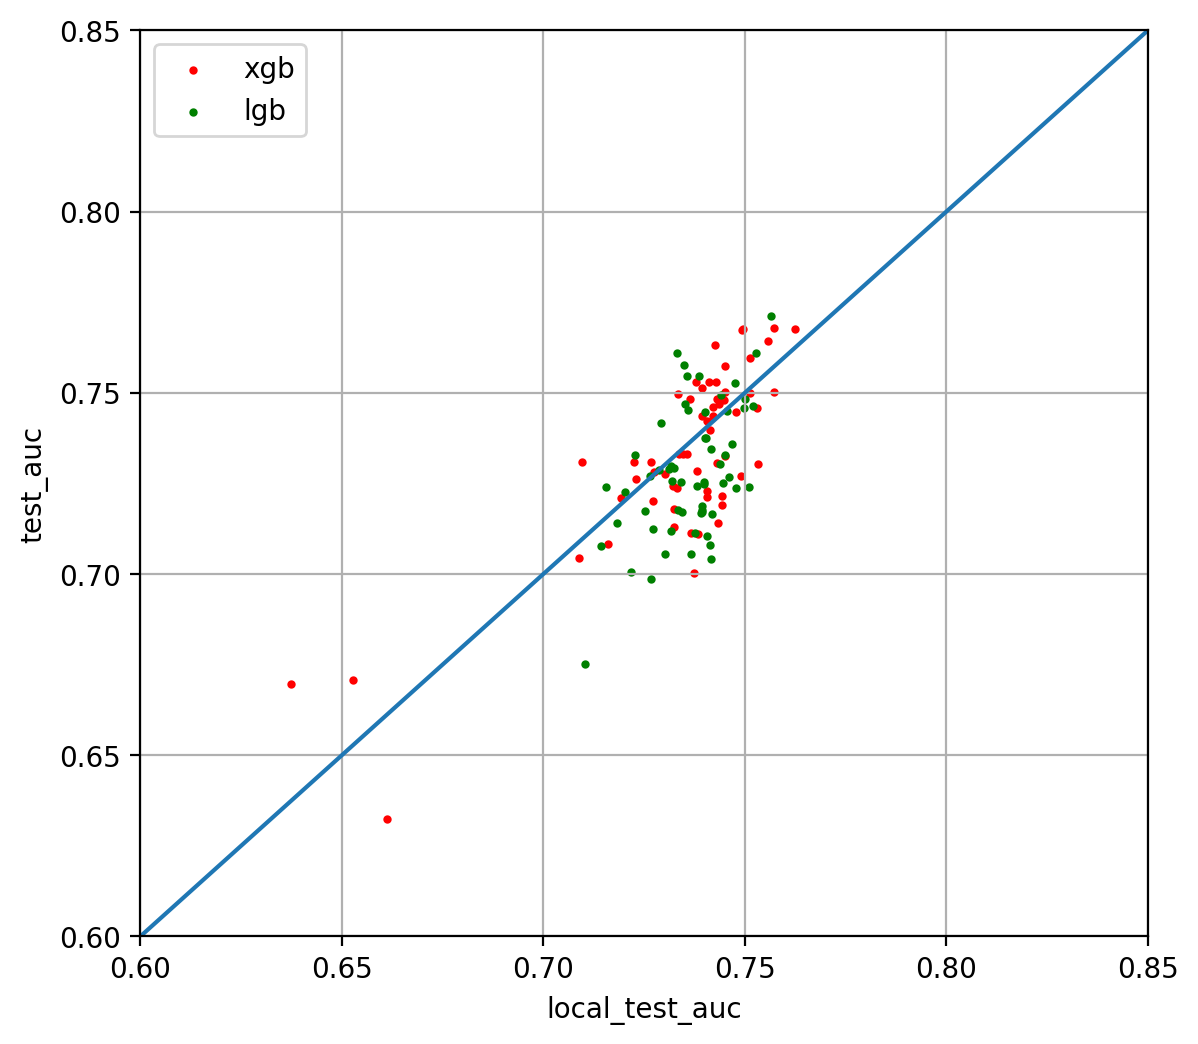

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6.5, 6), dpi=200)


plt.scatter(info_df[info_df['model'] == 'xgb']['sum_test_loss'], info_df[info_df['model'] == 'xgb']['test_auc'],
            c='r', s=4, label="xgb")
plt.scatter(info_df[info_df['model'] == 'lgb']['sum_test_loss'], info_df[info_df['model'] == 'lgb']['test_auc'],
            c='g', s=4, label="lgb")
# plt.scatter(info_df[info_df['model'] == 'cat']['local_test_auc'], info_df[info_df['model'] == 'cat']['test_auc'],
#             c='b', s=4,label="cat")
plt.legend()
plt.xlabel('local_test_auc')
plt.ylabel('test_auc')
plt.plot([0.6, 0.85], [0.6, 0.85])
plt.xlim(0.6, 0.85)
plt.ylim(0.6, 0.85)
plt.grid()
plt.show()


# 输出模块

## stacking

In [38]:
from sklearn.linear_model import LogisticRegression

xgb_res=[]
lgb_res=[]
temp=list(info_df['model'])
for i in range(N*2):
    if temp[i]=="xgb":
        xgb_res+=copy.deepcopy(local_test_labels[i])
    if temp[i]=="lgb":
        lgb_res+=copy.deepcopy(local_test_labels[i])

log_reg=LogisticRegression()
res_df=pd.DataFrame({"xgb":xgb_res,'lgb':lgb_res,'real':list(Y_local_test)*N})

log_reg.fit(res_df[['xgb','lgb']],res_df['real'])


LogisticRegression()

array([<AxesSubplot:title={'center':'xgb'}, xlabel='real'>,
       <AxesSubplot:title={'center':'lgb'}, xlabel='real'>], dtype=object)

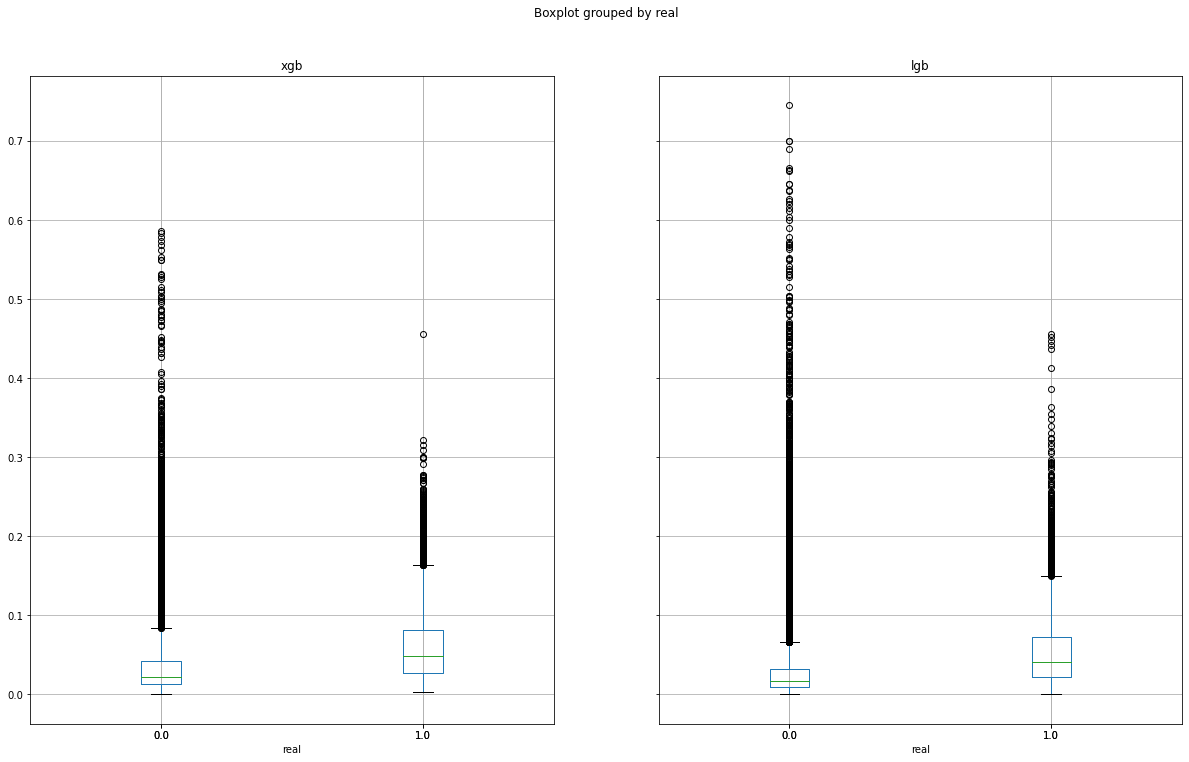

In [39]:
res_df.boxplot(['xgb','lgb'],by='real',figsize=[20,12])

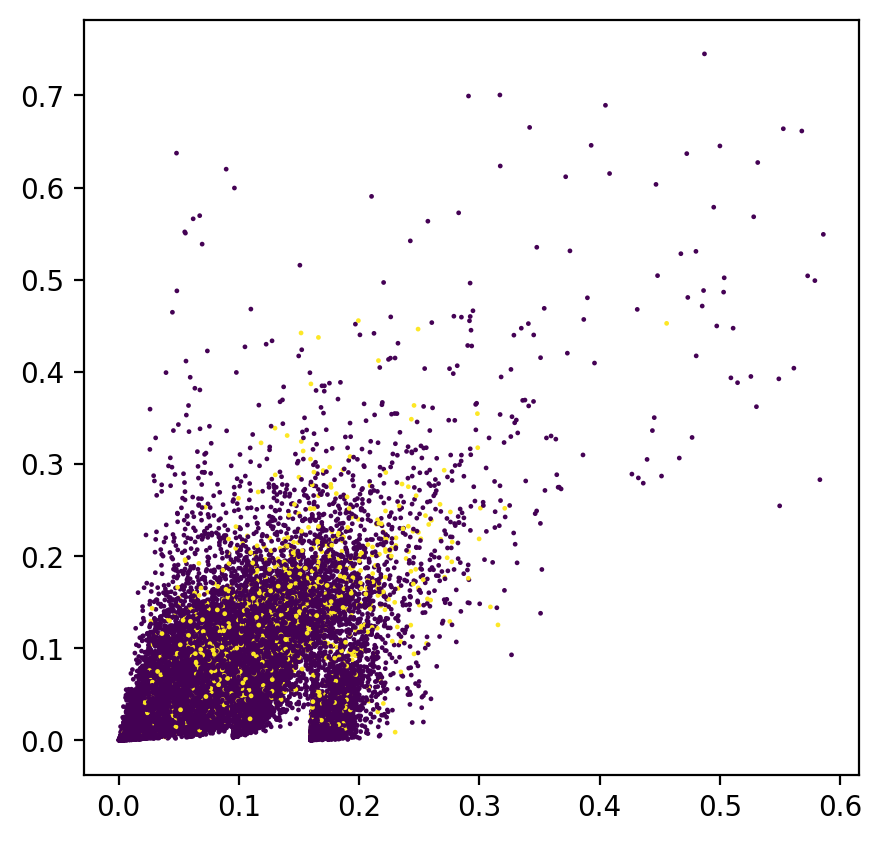

In [40]:
plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(xgb_res,lgb_res,s=0.5,c=list(Y_local_test)*N)

In [41]:
log_reg.coef_

array([[4.78126594, 7.74442736]])

In [42]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort(
    [-i for i in (info_df['sum_test_loss'])])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    auc_seq = []
    for i in range(N*2):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp = np.exp(np.mean(np.log(list_temp), axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        # print(i, temp_auc)
        auc_seq.append(temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 40
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(
    np.mean(np.log([pred_labels[i] for i in res_num]), axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)

print("平均之后local_test_AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


平均之后local_test_AUC为0.7684914545528356


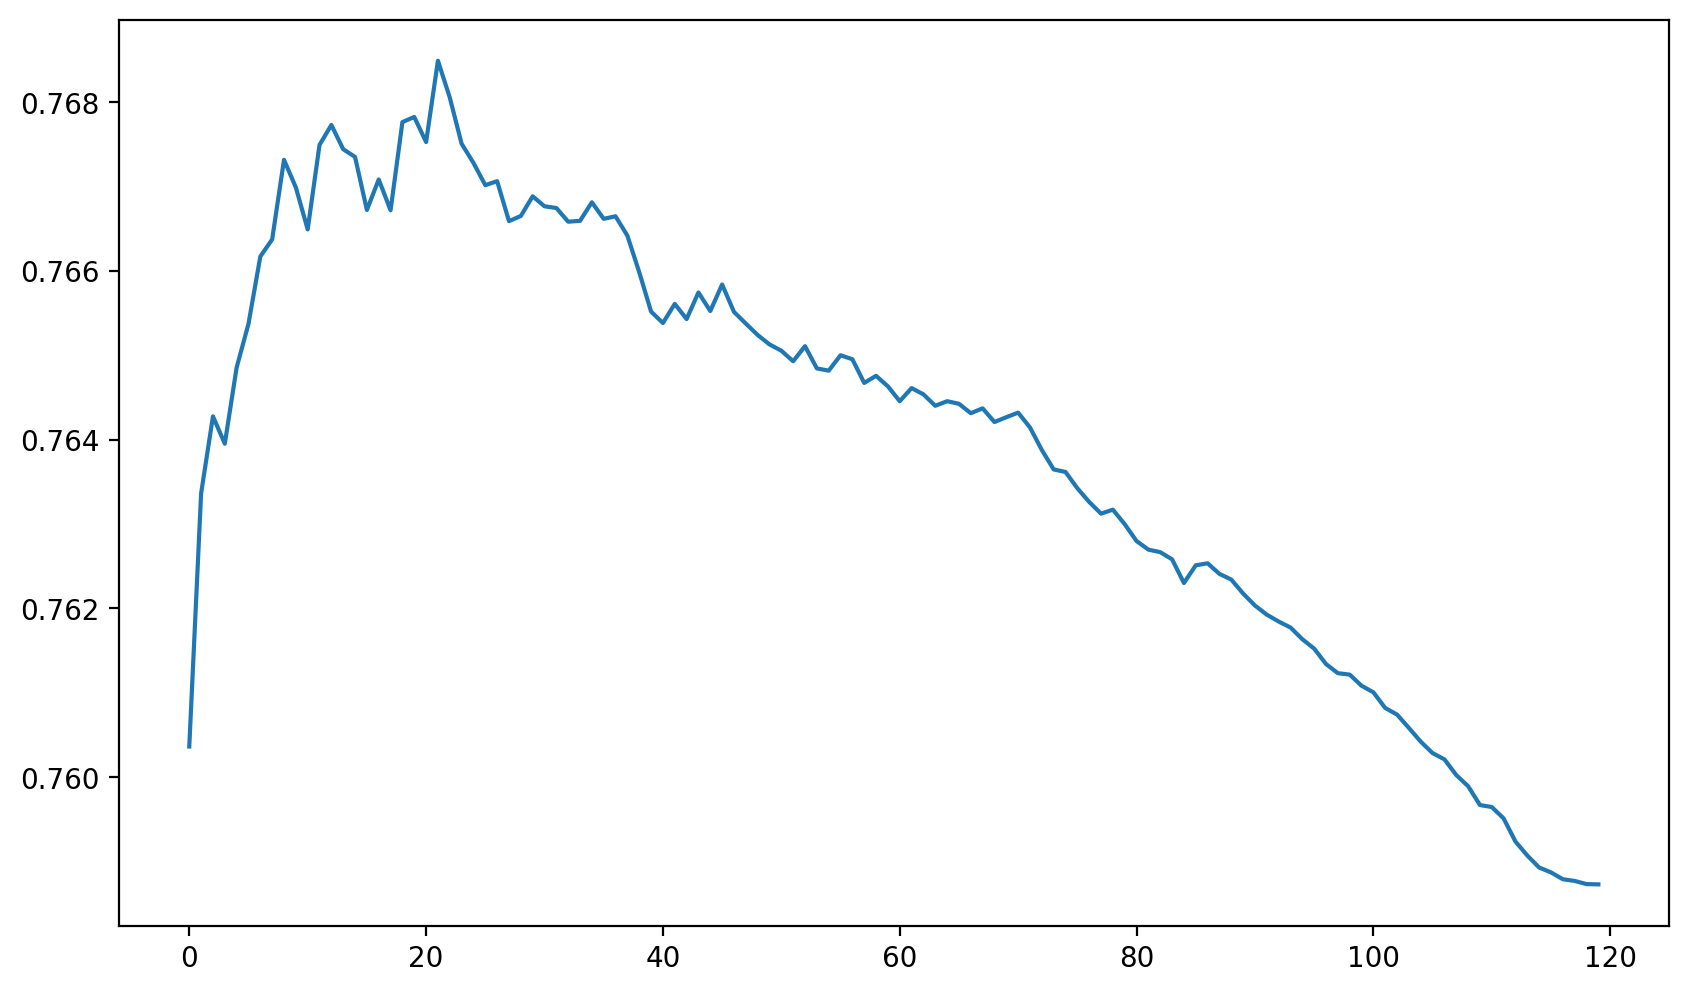

In [43]:

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(list(range(len(auc_seq))), auc_seq)


# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用
## 10-18
* 不能把industry之类种类很多的分类变量做证据权重

# 记录
* 1014-4
  * 0.6823
  * 证据权重
  * 未添加贷款记录表
  * 按test auc排序
* 1014-5
  * 0.6925
  * 按local test auc排序
* 1015-1
  * 0.6834
  * 处理-99
* 1015-2
  * 0.6628
  * 添加贷款记录表
* 1015-3
  * 0.6772
  * 不处理-99
  * 去除贷款记录表
  * 添加了type-col
* 1015-4
  * 0.6811
  * 不做证据权重
* 1015-5
  * 0.6765
  * gamma=0
* 1016-1
  * 0.6798
  * 添加gamma
  * 增大early stop round
* 1016-2
  * 0.6858
  * early stop round=10
  * 证据权重
* 1016-3
  * 0.685799
  * 使用原始type-col
* 1017-2
  * 0.6655
